# Task 2 - Dart Detection

Who doesn't love a great game? Maybe during beer friday, or after workday. But nobody likes to calculate. Let's delegate it to PC and let it decide who is the winner of the dart game

In [222]:
import os

import matplotlib.pyplot as plt
import cv2
import numpy as np
from roboflow import Roboflow
from dotenv import load_dotenv
load_dotenv()

True

## I tried several approaches and this is the first one.

1. We can detect the boundaries of each dart (green or red) as a rectangle, 
2. Calculate the middle point of that rectangle and cosider it as a point that was hitted.
3. Calculate the radius and center of the biggest outer circle
4. Divide radius by number of sectors (8 in our case)
5. Assign number of points depending on how far hit point is from center


## Crop and Resize

Firstly I want to crop image for aestetic reasons

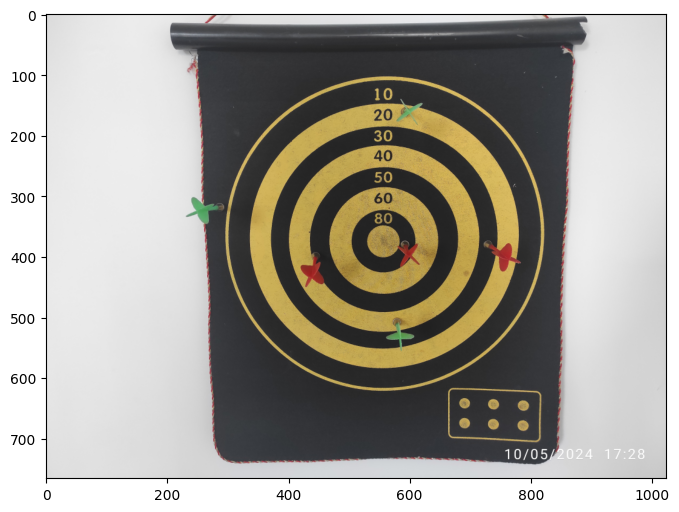

In [180]:
image_path = './data/bord2.jpg'
img = cv2.imread(image_path)

r = 1024.0 / img.shape[1]
dim = (1024, int(img.shape[0] * r))
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

plt.figure(figsize = (8,8))
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

In [183]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 72, 255, cv2.THRESH_BINARY_INV)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

target_contour = max(contours, key=cv2.contourArea)

x, y, w, h = cv2.boundingRect(target_contour)

cropped_image = resized[y:y+h, x:x+w]

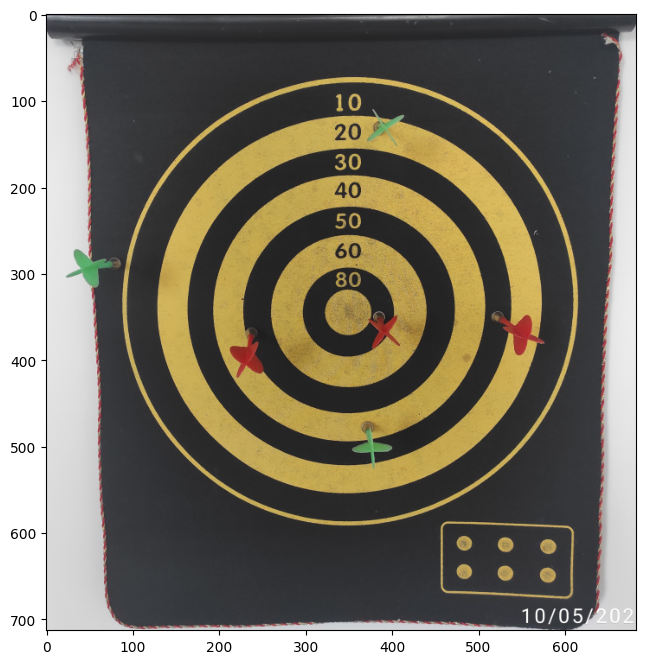

In [184]:
plt.figure(figsize = (8,8))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.show()

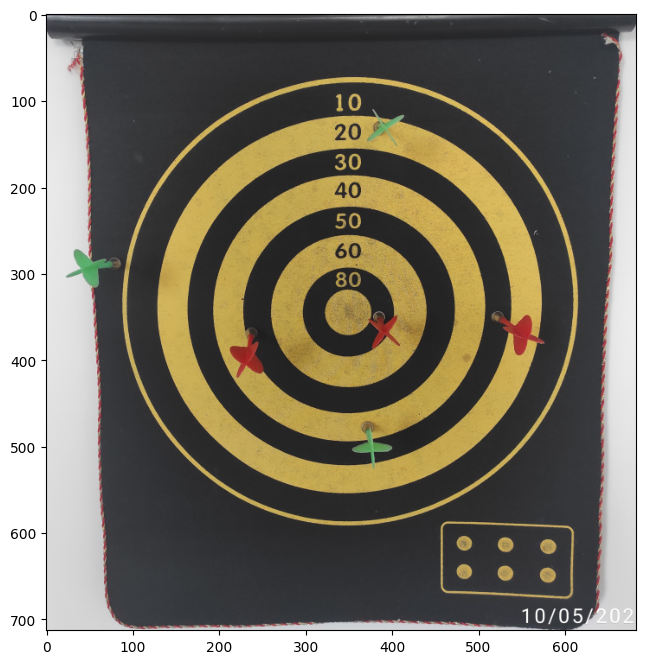

In [185]:
plt.figure(figsize = (8,8))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
cv2.imwrite('cropped_image.jpg', cropped_image)
plt.show()

In [186]:
board = cropped_image.copy()

## Boundary Detection

Using cv2 let's extract the image

Define the red and green spectrum and find the countours of image

In [187]:
hsv = cv2.cvtColor(board, cv2.COLOR_BGR2HSV)

lower_red = np.array([0, 120, 70])
upper_red = np.array([10, 255, 255])
lower_green = np.array([36, 45, 45])
upper_green = np.array([86, 255, 255])

mask_red = cv2.inRange(hsv, lower_red, upper_red)
mask_green = cv2.inRange(hsv, lower_green, upper_green)

contours_red, _ = cv2.findContours(mask_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_green, _ = cv2.findContours(mask_green, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Draw countours on each image, get only the big boxes that are detected, 
We filter out only big boundaries that have size more then 20

In [192]:
bounding_rects_red = [cv2.boundingRect(cnt) for cnt in contours_red if cv2.boundingRect(cnt)[2] > 20 and cv2.boundingRect(cnt)[3] > 20]
bounding_rects_green= [cv2.boundingRect(cnt) for cnt in contours_green if cv2.boundingRect(cnt)[2] > 20 and cv2.boundingRect(cnt)[3] > 20]

for x, y, w, h in bounding_rects_red:
    cv2.rectangle(board, (x, y), (x + w, y + h), (0, 0, 255), 2)

for x, y, w, h  in bounding_rects_green:
    cv2.rectangle(board, (x, y), (x + w, y + h), (0, 255, 0), 2)


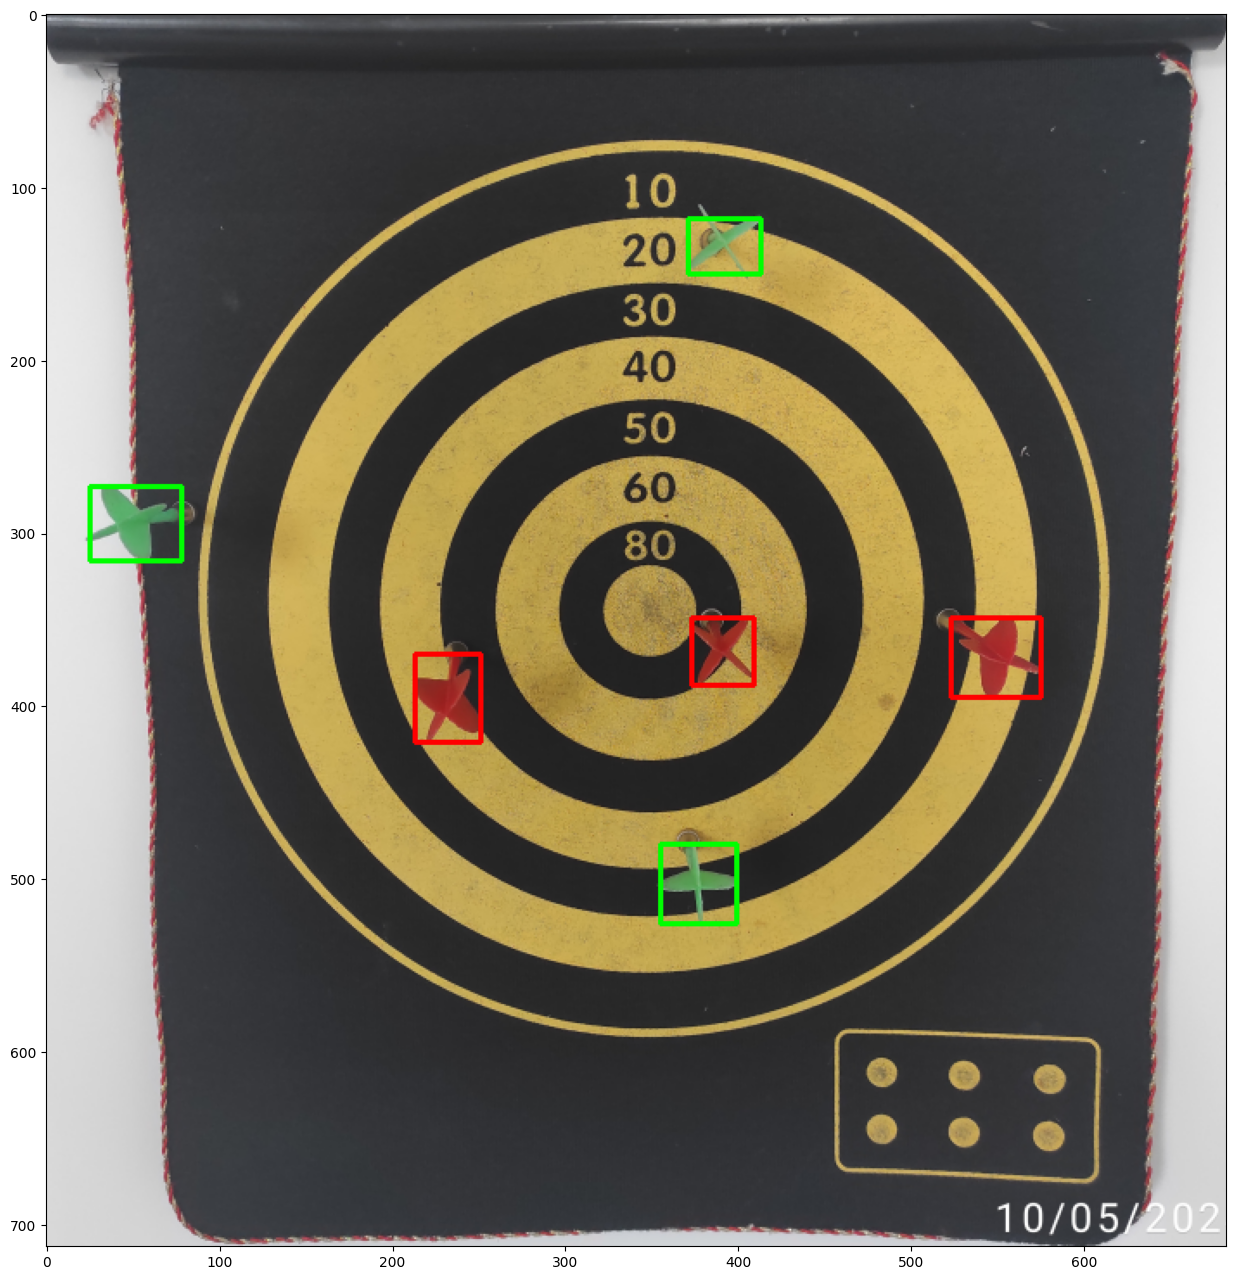

In [193]:
plt.figure(figsize = (16,16))
plt.imshow(cv2.cvtColor(board, cv2.COLOR_BGR2RGB))
cv2.imwrite('red-green-boundaries-circles.jpg', board)
plt.show()


Now we want to find the radius of outer circle and bulls eye of aim

In [194]:
gray_image = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)


img = cv2.medianBlur(gray_image, 5)

cv2.imwrite('grey-blur-image.jpg', img)


circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT,
                          dp=2, minDist=30, param1=20,
                          param2=0.9, minRadius=10)

circles = np.uint16(np.around(circles))


outer_circle = circles[0][circles[0][:, 2].argmax()]
cv2.circle(board, (outer_circle[0], outer_circle[1]), outer_circle[2], (255, 0, 0), 2)
cv2.circle(board, (outer_circle[0], outer_circle[1]), 2, (255, 0, 0), 3)

bullseye_radius = outer_circle[2]
bullseye_center = (outer_circle[0], outer_circle[1])

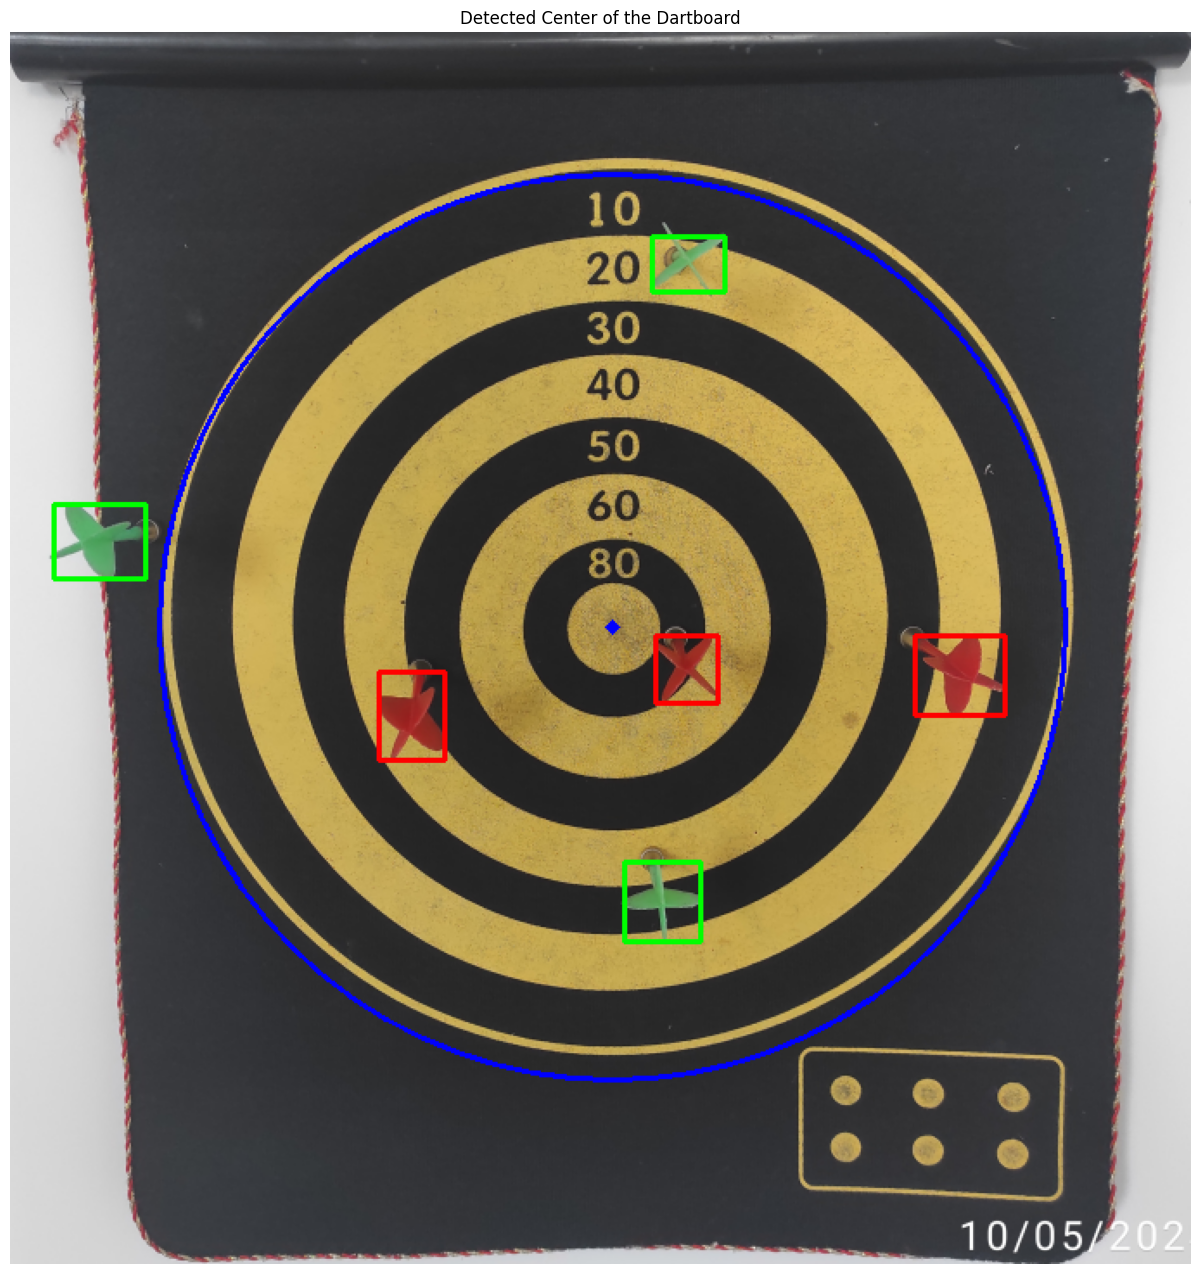

In [195]:
plt.figure(figsize = (16,16))
plt.imshow(cv2.cvtColor(board, cv2.COLOR_BGR2RGB))
plt.title('Detected Center of the Dartboard')
cv2.imwrite('red-green-boundaries-biggest-circle.jpg', board)
plt.axis('off')
plt.show()

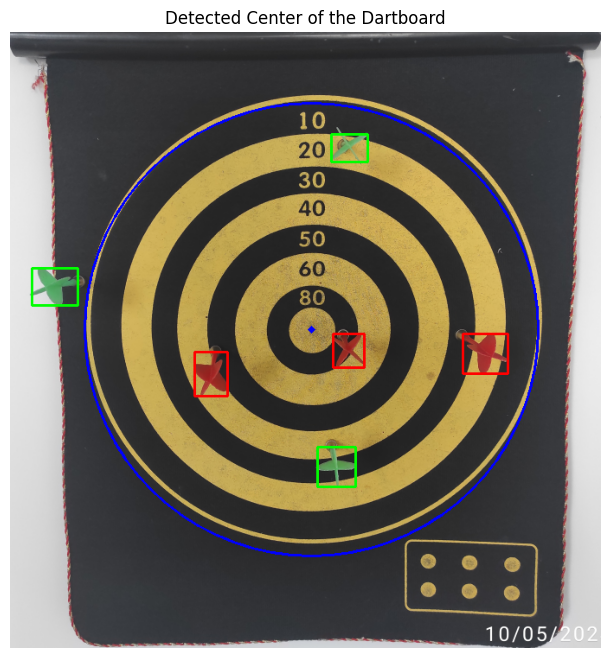

In [196]:
plt.figure(figsize = (8,8))
plt.imshow(cv2.cvtColor(board, cv2.COLOR_BGR2RGB))
plt.title('Detected Center of the Dartboard')
plt.axis('off')
plt.show()


## Scoring

---

Cool. We hypothetically know where are the darts hit and the center of aim 
We can calculate the scores of each player

This function will take the dart coordinates and calculate Euclidian distance from center. Then depending on distance we will return the points of each sector

In [197]:
def score_per_dart_depending_on_distance(step, center_of_dart, dart_coordinates):
    dart_coordinates = np.array(dart_coordinates)
    center_of_dart = np.array(center_of_dart)

    distance = np.linalg.norm(center_of_dart - dart_coordinates)
    sector = distance / step
    if sector <= 1:
        return 100
    elif sector <= 2:
        return 80
    elif sector <= 3:
        return 60
    elif sector <= 4:
        return 50
    elif sector <= 5:
        return 40
    elif sector <= 6:
        return 30
    elif sector <= 7:
        return 20
    elif sector <= 8:
        return 10
    
    return 0

And finally we want to calculate score 

In [206]:
def calculate_score_casual_cv(img, center_of_dart, radius, contours_green, contours_red):
    
    processing_image = img.copy()
    score_step = radius / 8
    players_aims = dict({'red': [], 'green': []})
    
    # Calculated centers of each dart for red and green player
    for  x, y, w, h in contours_red:
        center_red = (int(x + w / 2), int(y + h / 2))
        players_aims['red'].append(center_red)
        cv2.circle(processing_image, (center_red[0], center_red[1]), 2, (0, 128, 255), 3)
        
    for  x, y, w, h in contours_green:
        center_green = (int(x + w / 2), int(y + h / 2))
        players_aims['green'].append(center_green)
        cv2.circle(processing_image, (center_green[0], center_green[1]), 2, (0, 128, 255), 3)


    score_red, score_green = 0, 0

    # Calculated score for each player
    for point in players_aims['red']:
        tmp_score = score_per_dart_depending_on_distance(score_step, point, center_of_dart)
        score_red += tmp_score
        
    print("score red", score_red)
    for point in players_aims['green']:
        tmp_score = score_per_dart_depending_on_distance(score_step, point, center_of_dart)
        score_green += tmp_score

    print("score green", score_green)

    # Deside who won
    if score_red > score_green:
        game_result = "red player won"
    elif score_green > score_red:
        game_result = "green player won"
    else:
        game_result = "draw"
    
    
    print(game_result)
    return processing_image, game_result, score_green, score_red

output_score_image, game_result, green_score, red_score = calculate_score_casual_cv(board, bullseye_center, bullseye_radius, bounding_rects_green, bounding_rects_red)

score red 150
score green 60
red player won


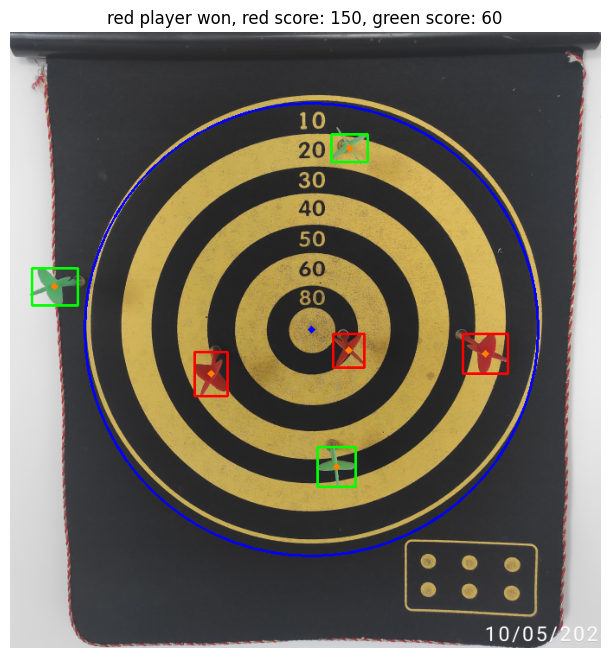

In [207]:
plt.figure(figsize = (8,8))
plt.imshow(cv2.cvtColor(output_score_image, cv2.COLOR_BGR2RGB))
plt.title(f'{game_result}, red score: {red_score}, green score: {green_score}')
plt.axis('off')
plt.show()

# Combining everything that is above, together

Let's test on on other images.

In [216]:
def dart_game_decision_casual_cv(image_path):
    # Reading image
    img = cv2.imread(image_path)


    # Resizing Image
    r = 1024.0 / img.shape[1]
    dim = (1024, int(img.shape[0] * r))
    resized_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    
            
    # Detecting darts' tails 
    hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    lower_green = np.array([36, 45, 45])
    upper_green = np.array([86, 255, 255])

    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    contours_red, _ = cv2.findContours(mask_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_green, _ = cv2.findContours(mask_green, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Drawing boundaries around darts' tails
    bounding_rects_red = [cv2.boundingRect(cnt) for cnt in contours_red if cv2.boundingRect(cnt)[2] > 20 and cv2.boundingRect(cnt)[3] > 20]
    bounding_rects_green= [cv2.boundingRect(cnt) for cnt in contours_green if cv2.boundingRect(cnt)[2] > 20 and cv2.boundingRect(cnt)[3] > 20]
    
    for x, y, w, h in bounding_rects_red:
        cv2.rectangle(resized_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    for x, y, w, h  in bounding_rects_green:
        cv2.rectangle(resized_image, (x, y), (x + w, y + h), (0, 255, 0), 2)


    # Converting back to rgb
    rgb_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    
    # Finding circles on image
    img = cv2.medianBlur(gray_image, 5)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT,
                              dp=2, minDist=30, param1=20,
                              param2=0.9, minRadius=200)
    
    circles = np.uint16(np.around(circles))
    
    outer_circle = circles[0][circles[0][:, 2].argmax()]
    cv2.circle(resized_image, (outer_circle[0], outer_circle[1]), outer_circle[2], (255, 0, 0), 2)
    cv2.circle(resized_image, (outer_circle[0], outer_circle[1]), 2, (255, 0, 0), 3)

    bullseye_radius = outer_circle[2]
    bullseye_center = (outer_circle[0], outer_circle[1])

    print(f"center: {bullseye_center}, radius: {bullseye_radius}")

    output_score_image, game_result, green_score, red_score = calculate_score_casual_cv(resized_image, bullseye_center, bullseye_radius, bounding_rects_green, bounding_rects_red)
   
    cv2.putText(output_score_image, f'{game_result}, red score: {red_score}, green score: {green_score}',
                (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2,cv2.LINE_AA)
    plt.figure(figsize = (8,8))
    plt.imshow(cv2.cvtColor(output_score_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite('score.png', output_score_image)
    plt.title(f'{game_result}, red score: {red_score}, green score: {green_score}')
    plt.axis('off')
    plt.show()
    

# Results 

Let's check results of algorithm on inital pictures

center: (546, 410), radius: 233
score red 180
score green 130
red player won


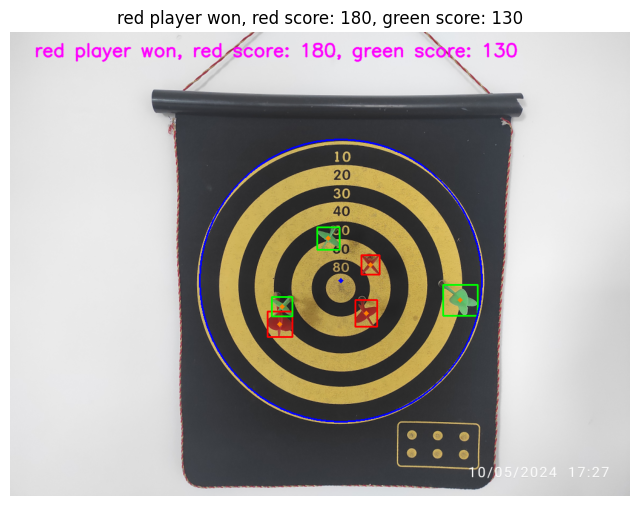

In [229]:
dart_game_decision_casual_cv('./data/bord1.jpg')

center: (564, 360), radius: 259
score red 140
score green 50
red player won


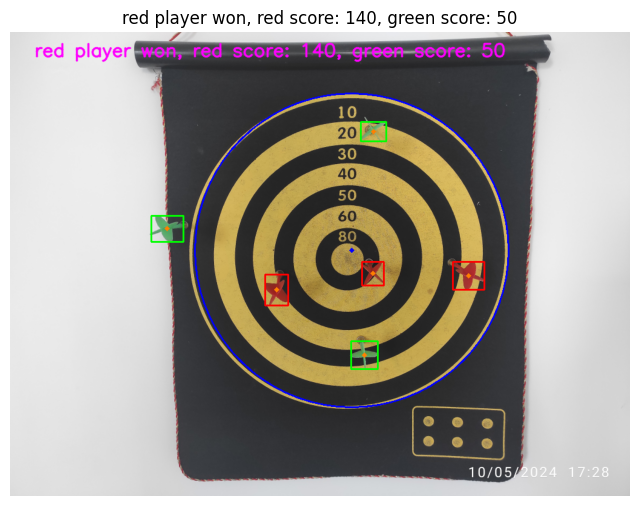

In [230]:
dart_game_decision_casual_cv('./data/bord2.jpg')


center: (548, 398), radius: 301
score red 160
score green 70
red player won


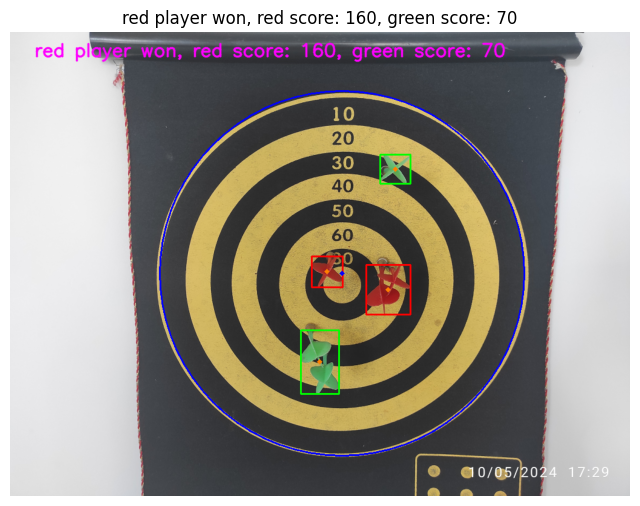

In [231]:
dart_game_decision_casual_cv('./data/bord3.jpg')



# Results weren't pretty good pretty accurate but not the best ones. I was thinking on using YOLO for image object detection but the problem was that I haven't enought data to train


I have created a dataset of 400 photos of darts, and trainer YOLOv7 on it, below is the API of Roboflow that is used to use hosted model.

You can use my API key for that 


In [223]:
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace().project(os.getenv("ROBOFLOW_PROJECT"))
model = project.version(os.getenv("YOLO_TRAINED_MODEL_VERSION")).model

loading Roboflow workspace...
loading Roboflow project...


In [224]:
def calculate_score_yolo(img, center_of_dart, radius, yolo_boxes):

    processing_image = img.copy()
    score_step = radius / 8
    print(score_step)
    players_aims = dict({'red': [], 'green': []})

    if yolo_boxes:
        for box in yolo_boxes:
            x, y, width, height, dart_class = int(box['x']), int(box['y']), int(box['width']), int(box['height']), box['class']
            center_green = (int(x + width / 2), int(y + height / 2))
            if dart_class == 'green-dart':
                players_aims['green'].append(center_green)
            else:
                players_aims['red'].append(center_green)

    score_red, score_green = 0, 0

    # Calculated score for each player
    for point in players_aims['red']:
        tmp_score = score_per_dart_depending_on_distance(score_step, point, center_of_dart)
        score_red += tmp_score

    print("score red", score_red)
    for point in players_aims['green']:
        tmp_score = score_per_dart_depending_on_distance(score_step, point, center_of_dart)
        score_green += tmp_score

    print("score green", score_green)

    # Deside who won
    if score_red > score_green:
        game_result = "red player won"
    elif score_green > score_red:
        game_result = "green player won"
    else:
        game_result = "draw"


    print(game_result)
    return processing_image, game_result, score_green, score_red


In [225]:
def dart_game_decision_yolo(image_path):
    # model api init
    rf = Roboflow(api_key="paste-your-apy-key")
    project = rf.workspace().project("darts-kidqv")
    model = project.version('4').model


    # Reading image
    img = cv2.imread(image_path)

    # Resizing Image
    r = 1024.0 / img.shape[1]
    dim = (1024, int(img.shape[0] * r))
    resized_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    image_for_yolo = resized_image.copy()


    # Detecting darts' tails 
    hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    lower_green = np.array([36, 45, 45])
    upper_green = np.array([86, 255, 255])

    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    contours_red, _ = cv2.findContours(mask_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_green, _ = cv2.findContours(mask_green, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Converting back to rgb
    rgb_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # Finding circles on image
    img = cv2.medianBlur(gray_image, 5)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT,
                               dp=2, minDist=30, param1=20,
                               param2=0.9, minRadius=200)

    circles = np.uint16(np.around(circles))

    outer_circle = circles[0][circles[0][:, 2].argmax()]
    cv2.circle(resized_image, (outer_circle[0], outer_circle[1]), outer_circle[2], (255, 0, 0), 2)
    cv2.circle(resized_image, (outer_circle[0], outer_circle[1]), 2, (255, 0, 0), 3)

    bullseye_radius = outer_circle[2]
    bullseye_center = (outer_circle[0], outer_circle[1])

    print(f"center: {bullseye_center}, radius: {bullseye_radius}")

    # predicting boundary boxes using Yolo
    predictions = model.predict(image_for_yolo, confidence=10, overlap=50).json()
    bounding_boxes = predictions['predictions']
    for box in bounding_boxes:
        x, y, width, height, dart_class = box['x'], box['y'], box['width'], box['height'], box['class']
        cv2.rectangle(resized_image, (int(x), int(y)), (int(x) + int(width), int(y) + int(height)), (255, 0, 255), 2)
        
    yolo_bounding_boxes = bounding_boxes

    output_score_image, game_result, green_score, red_score = calculate_score_yolo(resized_image, 
                                                                                   bullseye_center, 
                                                                                   bullseye_radius, 
                                                                                   yolo_bounding_boxes)

    cv2.putText(output_score_image, f'{game_result}, red score: {red_score}, green score: {green_score}',
                (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2,cv2.LINE_AA)
    plt.figure(figsize = (8,8))
    plt.imshow(cv2.cvtColor(output_score_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite('score.png', output_score_image)
    plt.title(f'{game_result}, red score: {red_score}, green score: {green_score}')
    plt.axis('off')
    plt.show()
    

loading Roboflow workspace...
loading Roboflow project...
center: (548, 398), radius: 301
37.625
score red 160
score green 150
red player won


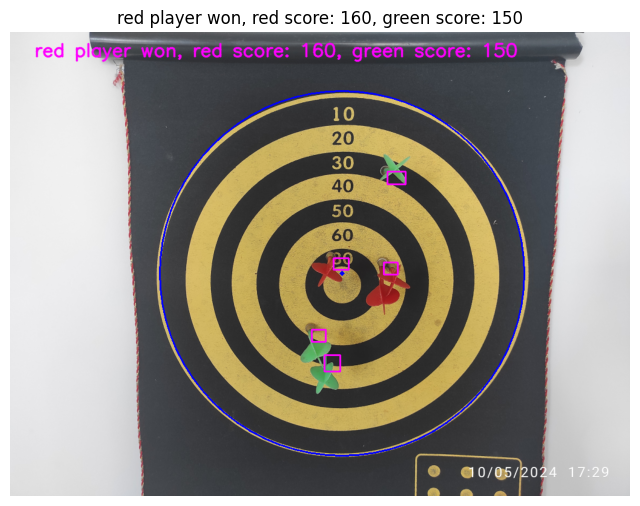

In [226]:
dart_game_decision_yolo("./data/bord1.jpg")

loading Roboflow workspace...
loading Roboflow project...
center: (564, 360), radius: 259
32.375
score red 160
score green 60
red player won


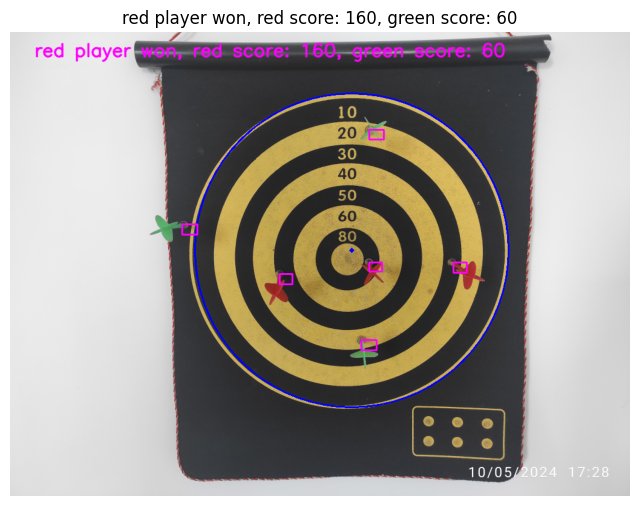

In [227]:
dart_game_decision_yolo("./data/bord2.jpg")

loading Roboflow workspace...
loading Roboflow project...
center: (546, 410), radius: 233
29.125
score red 120
score green 80
red player won


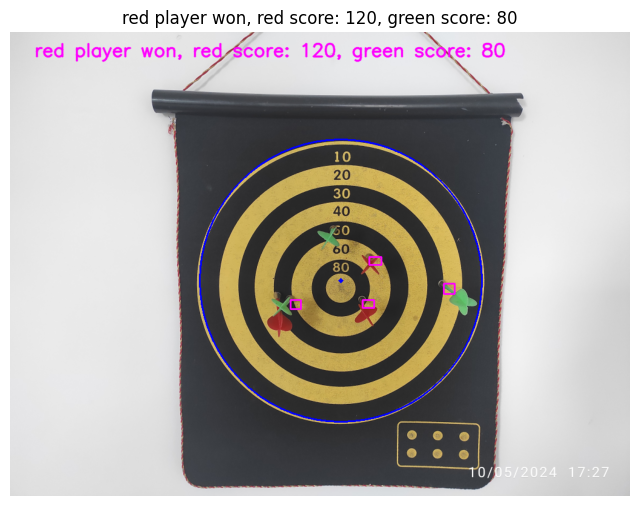

In [228]:
dart_game_decision_yolo("./data/bord3.jpg")